# Phase 4 NLP ML Project


![Image Description](Image/Twitter1.png)

# Activate Env

In [1]:
conda activate TFgpu


Note: you may need to restart the kernel to use updated packages.


# Load Python Packages & DF

In [88]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import string
import re
import unicodedata
from collections import Counter
from wordcloud import WordCloud
from afinn import Afinn
from nltk.corpus import sentiwordnet as swn
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [89]:
# Read the dataset
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')

# Remove tweets with unknown sentiment
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

In [90]:
# Create Cleaning Function
def clean_text(text_series, custom_stopwords=None):
    def clean_single_text(text):
        if pd.isnull(text):
            return ''
        else:
            text = text.lower()
            text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
            text = re.sub(r'@\w+', 'USER', text)
            text = re.sub(r'http\S+|www\S+', 'URL', text)
            text = re.sub(r'[^\w\s#]', '', text)
            tokens = nltk.word_tokenize(text)
            stop_words = set(stopwords.words('english'))
            if custom_stopwords:
                stop_words.update(custom_stopwords)
            tokens = [token for token in tokens if token not in stop_words]
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
            return ' '.join(tokens)
    
    return text_series.apply(clean_single_text)

In [91]:
# Load and preprocess the data
X = df['tweet_text']
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

In [92]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
# Create the TfidfVectorizer with max_df
max_df = 0.9  # Exclude terms that have a document frequency higher than 90%
vectorizer = TfidfVectorizer(max_df=max_df)

In [94]:
# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', FunctionTransformer(clean_text)),  # Custom text preprocessing
    ('tfidf', TfidfVectorizer()),  # TF-IDF feature extraction
    ('classifier', DummyClassifier(strategy='most_frequent'))  # Dummy Classifier
])

# Train the model and make predictions
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1.0)

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1.0)

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1.0)

# Print the evaluation metrics
print(f'DummyClassifier Accuracy: {accuracy}')
print(f'DummyClassifier Precision: {precision}')
print(f'DummyClassifier Recall: {recall}')
print(f'DummyClassifier F1-score: {f1}')

DummyClassifier Accuracy: 0.6124161073825504
DummyClassifier Precision: 0.7626373811990451
DummyClassifier Recall: 0.6124161073825504
DummyClassifier F1-score: 0.4652068245465783


In [126]:
# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', FunctionTransformer(clean_text)),  # Custom text preprocessing
    ('tfidf', TfidfVectorizer()),  # TF-IDF feature extraction
    ('classifier', MultinomialNB())  # Naive Bayes classifier
])

# Define the hyperparameters to search
hyperparameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # N-gram range for TF-IDF
    'classifier__alpha': [0.1, 1.0, 10.0]  # Smoothing parameter for Naive Bayes
}

# Perform grid search
grid_search = GridSearchCV(pipeline, hyperparameters, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_hyperparameters = grid_search.best_params_
print(f'Best Hyperparameters: {best_hyperparameters}')

# Use the best hyperparameters in the MultinomialNB model
best_model = Pipeline([
    ('preprocessor', FunctionTransformer(clean_text)),
    ('tfidf', TfidfVectorizer(ngram_range=best_hyperparameters['tfidf__ngram_range'])),
    ('classifier', MultinomialNB(alpha=best_hyperparameters['classifier__alpha']))
])

# Train the model using the best hyperparameters
best_model.fit(X_train, y_train)

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1.0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1.0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1.0)

# Generate the classification report
classification_report = classification_report(y_test, y_pred)

# Print the evaluation metrics and classification report
print(f'MultinomialNB Accuracy: {accuracy}')
print(f'MultinomialNB Precision: {precision}')
print(f'MultinomialNB Recall: {recall}')
print(f'MultinomialNB F1-score: {f1}')
print('Classification Report:')
print(classification_report)


Best Hyperparameters: {'classifier__alpha': 0.1, 'tfidf__ngram_range': (1, 2)}
MultinomialNB Accuracy: 0.6649888143176734
MultinomialNB Precision: 0.6559701058641508
MultinomialNB Recall: 0.6649888143176734
MultinomialNB F1-score: 0.6529904111697196
Classification Report:
                                    precision    recall  f1-score   support

                  Negative emotion       0.59      0.21      0.31       122
No emotion toward brand or product       0.72      0.79      0.75      1095
                  Positive emotion       0.56      0.52      0.54       571

                          accuracy                           0.66      1788
                         macro avg       0.62      0.51      0.53      1788
                      weighted avg       0.66      0.66      0.65      1788



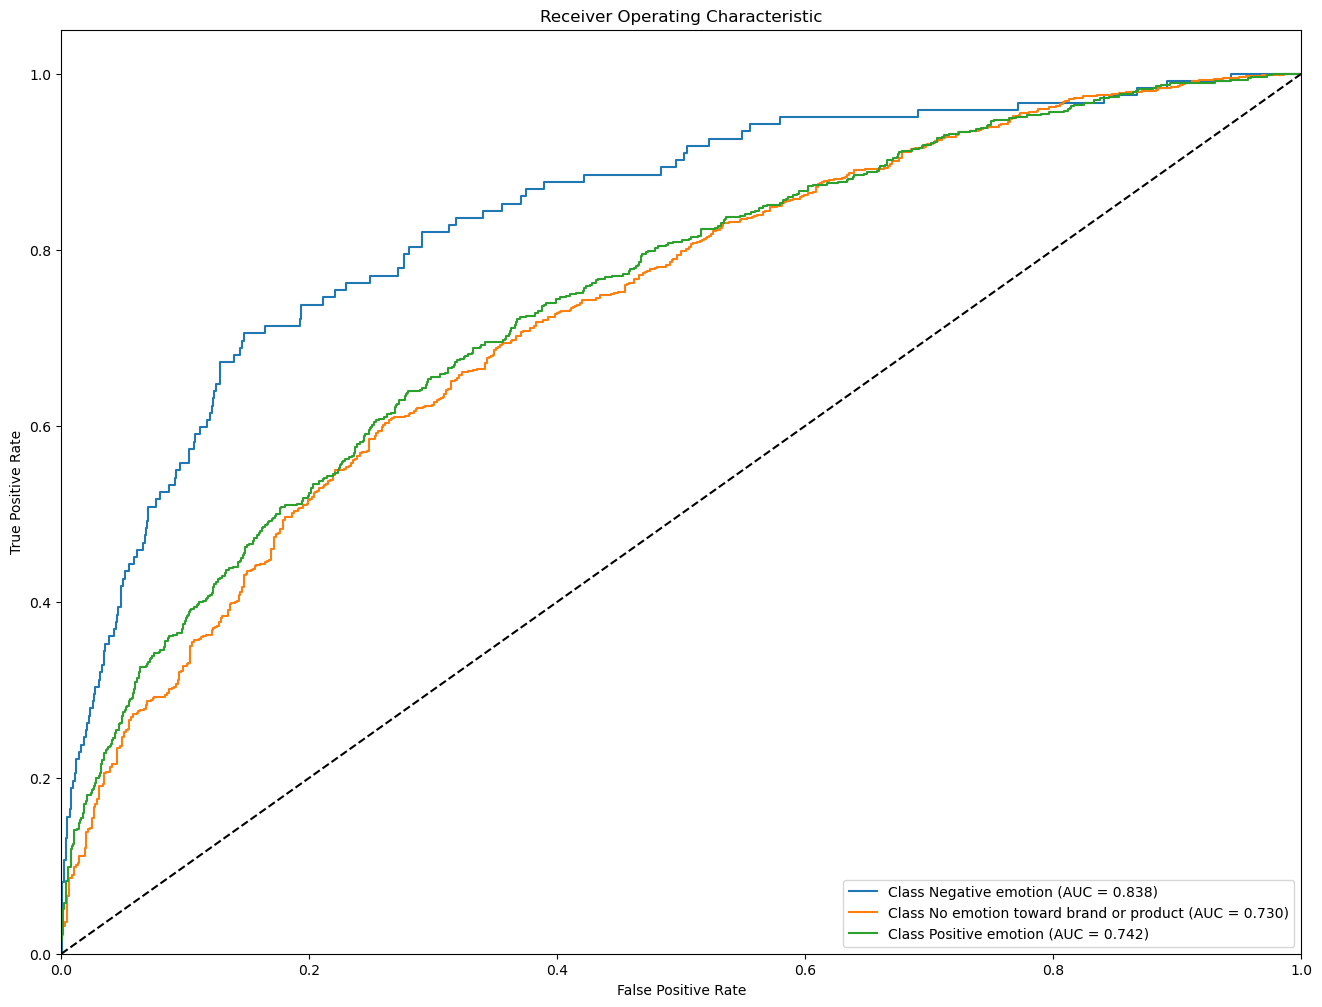

In [131]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Preprocess the text data using the best preprocessor
X_train_preprocessed = best_model.named_steps['preprocessor'].transform(X_train)
X_test_preprocessed = best_model.named_steps['preprocessor'].transform(X_test)

# Fit the model using the best hyperparameters
best_model.fit(X_train_preprocessed, y_train)

# Make predictions using the best model
y_pred_prob = best_model.predict_proba(X_test_preprocessed)

# Calculate the false positive rate, true positive rate, and AUC-ROC score for each class
fpr = dict()
tpr = dict()
auc_roc = dict()

for i in range(len(best_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == best_model.classes_[i], y_pred_prob[:, i])
    auc_roc[i] = roc_auc_score(y_test == best_model.classes_[i], y_pred_prob[:, i])

# Plot the ROC curves for each class
plt.figure(figsize=(16, 12))
for i in range(len(best_model.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {best_model.classes_[i]} (AUC = {auc_roc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Load and preprocess the data
X = df['tweet_text']
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

# Handle missing values in the text data
X = X.fillna('')  # Replace missing values with empty strings

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline for text preprocessing and feature extraction
preprocessor = TfidfVectorizer()

# Fit and transform the text data using the preprocessor
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define the individual models
model1 = MultinomialNB(alpha=0.1)
model2 = SVC(kernel='linear', probability=True)
model3 = RandomForestClassifier(n_estimators=100)

# Create the voting classifier
voting_classifier = VotingClassifier(
    estimators=[('nb', model1), ('svm', model2), ('rf', model3)],
    voting='soft'  # Use soft voting for probability-based prediction averaging
)


In [110]:
# Train the ensemble model
voting_classifier.fit(X_train_preprocessed, y_train)

VotingClassifier(estimators=[('nb', MultinomialNB(alpha=0.1)),
                             ('svm', SVC(kernel='linear', probability=True)),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [111]:
# Make predictions using the ensemble model
y_pred = voting_classifier.predict(X_test_preprocessed)

In [118]:
from sklearn.metrics import classification_report

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1.0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1.0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1.0)

# Generate the classification report
classification_report_output = classification_report(y_test, y_pred)

# Print the evaluation metrics and classification report
print(f'Ensemble Accuracy: {accuracy}')
print(f'Ensemble Precision: {precision}')
print(f'Ensemble Recall: {recall}')
print(f'Ensemble F1-score: {f1}')
print('Classification Report:')
print(classification_report_output)


Ensemble Accuracy: 0.6991051454138703
Ensemble Precision: 0.6861577490853177
Ensemble Recall: 0.6991051454138703
Ensemble F1-score: 0.6790867407903003
Classification Report:
                                    precision    recall  f1-score   support

                  Negative emotion       0.58      0.21      0.31       122
No emotion toward brand or product       0.72      0.87      0.79      1095
                  Positive emotion       0.64      0.48      0.55       571

                          accuracy                           0.70      1788
                         macro avg       0.65      0.52      0.55      1788
                      weighted avg       0.69      0.70      0.68      1788



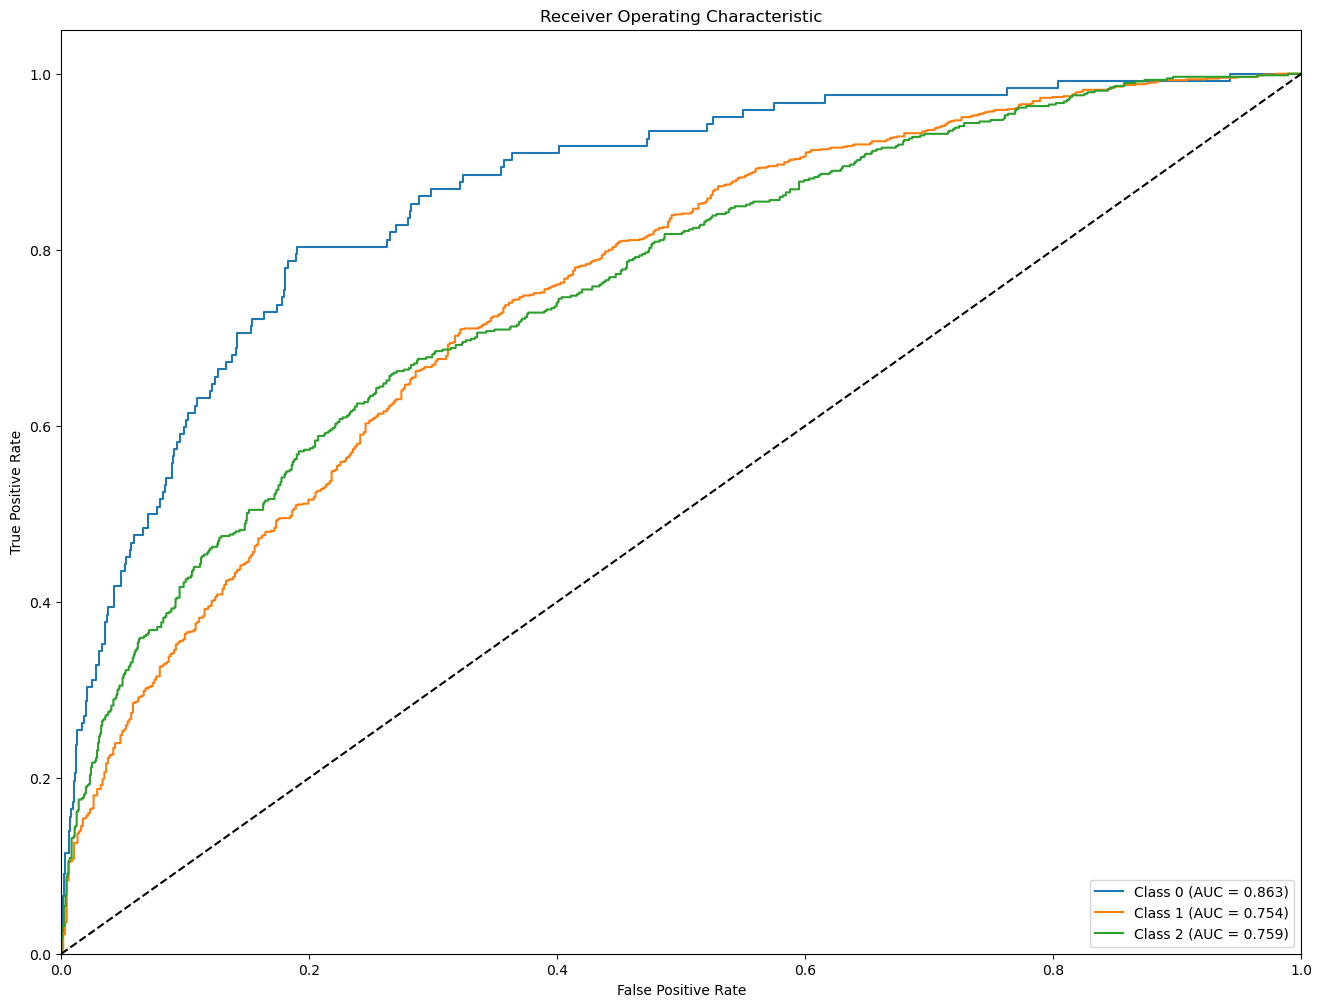

In [122]:
from sklearn.preprocessing import label_binarize

# Convert the target variable to binary format
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Generate the predicted probabilities for each class
y_pred_prob = voting_classifier.predict_proba(X_test_preprocessed)

# Calculate the false positive rate, true positive rate, and AUC-ROC score for each class
fpr = dict()
tpr = dict()
auc_roc = dict()

for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    auc_roc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])

# Plot the ROC curves for each class
plt.figure(figsize=(16, 12))
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {auc_roc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


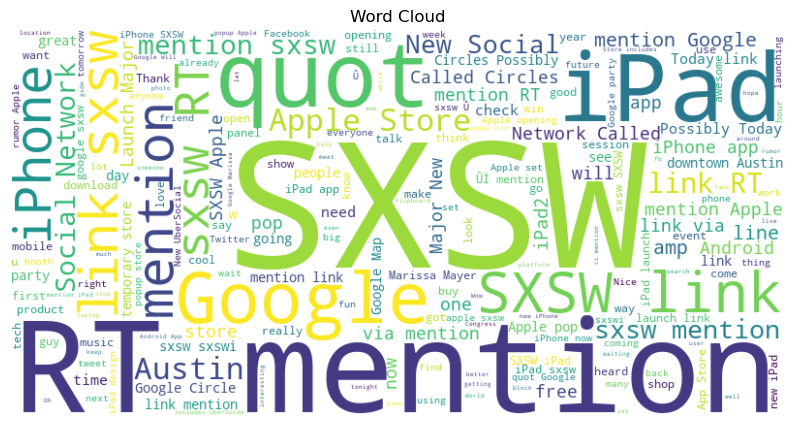

In [123]:
# Convert non-string values to strings
X_WC = X.astype(str)

# Combine the tweets into a single string
wc = ' '.join(X_WC)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wc)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()


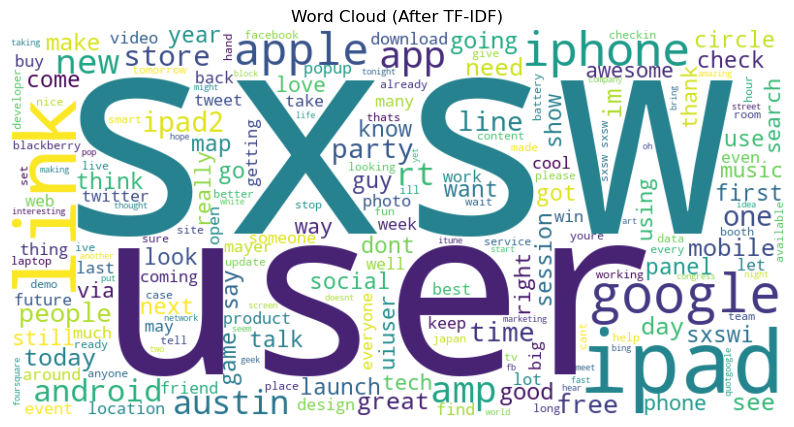

In [124]:
# Get the TF-IDF vectorizer from the best model
tfidf_vectorizer = best_model.named_steps['tfidf']

# Get the feature names (words) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a dictionary of feature names and their TF-IDF scores
feature_scores = dict(zip(feature_names, X_tfidf.sum(axis=0).A1))

# Sort the dictionary by TF-IDF scores in descending order
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Extract the words remaining after TF-IDF
words_remaining = [word for word, score in sorted_features]

# Create a word cloud of the words remaining after TF-IDF
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words_remaining))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (After TF-IDF)')
plt.show()


In [119]:
# Load and preprocess the data
X = df['tweet_text']
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

# Handle missing values in the text data
X = X.fillna('')  # Replace missing values with empty strings

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the pipeline for text preprocessing and feature extraction
preprocessor = TfidfVectorizer()

# Fit and transform the text data using the preprocessor
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Define the individual models
model1 = MultinomialNB(alpha=0.1)
model2 = SVC(kernel='linear', probability=True)
model3 = RandomForestClassifier(n_estimators=100)

# Create the voting classifier
voting_classifier = VotingClassifier(
    estimators=[('nb', model1), ('svm', model2), ('rf', model3)],
    voting='soft'  # Use soft voting for probability-based prediction averaging
)

# Train the ensemble model
voting_classifier.fit(X_train_preprocessed, y_train)

# Make predictions using the ensemble model
y_pred = voting_classifier.predict(X_test_preprocessed)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1.0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1.0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1.0)


from sklearn.metrics import classification_report

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1.0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1.0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1.0)

# Generate the classification report
classification_report_output = classification_report(y_test, y_pred)

# Print the evaluation metrics and classification report
print(f'Ensemble Accuracy: {accuracy}')
print(f'Ensemble Precision: {precision}')
print(f'Ensemble Recall: {recall}')
print(f'Ensemble F1-score: {f1}')
print('Classification Report:')
print(classification_report_output)


Ensemble Accuracy: 0.6935123042505593
Ensemble Precision: 0.6803227583201408
Ensemble Recall: 0.6935123042505593
Ensemble F1-score: 0.6737796197611243
Classification Report:
                                    precision    recall  f1-score   support

                  Negative emotion       0.59      0.22      0.32       122
No emotion toward brand or product       0.72      0.86      0.78      1095
                  Positive emotion       0.62      0.47      0.54       571

                          accuracy                           0.69      1788
                         macro avg       0.64      0.52      0.55      1788
                      weighted avg       0.68      0.69      0.67      1788

